# Unsupervised learning with Autoencoder

We first ibuild a very simple autoencoder (AE) and play with MNIST dataset.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

## Loading MNIST

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [ ]:
# to be modified if not on colab
root_dir = './data/MNIST/'
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

## Helper Functions

In [ ]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

## 0. Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
input_dim = 784
encoding_dim = 64

model = AutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

Why did we take 784 as input dimension?

To find the learning rate, see the documentation for [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [ ]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.128072
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.046665
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.033900
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.030524
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.026895
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.023506
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.021957
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.021683
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.020380
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.020000
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.020435
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.018965
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.019781
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.019838
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.019330
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.019127
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.018997
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.018527
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.018881
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.018166
Train Epoch: 6 [51200/60000 (85%)]	

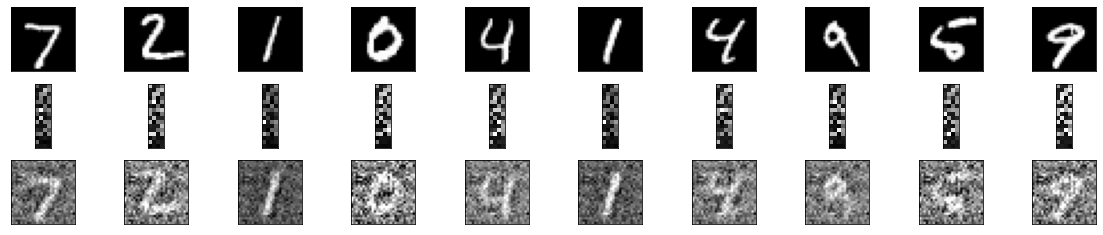

In [ ]:
plot_reconstructions(model)

## 1. Implement a stacked Autoencoder

Now you will code an autoencoder where both the encoder and the decoder are multilayer perceptron (MLP). You can take for the encoder a first hidden layer with dimension 128, a second one with dimension 64 and then the code of dimension 32. For the decoder, you can take the same sequence of dimensions in reverse order.

In [ ]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=784),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [ ]:
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.104763
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.056353
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.038377
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.035072
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.033016
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.029568
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.028180
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.027026
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.025902
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.026523
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.027295
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.026404
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.026077
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.023620
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.023728
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.024346
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.023310
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.023688
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.022257
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.021837
Train Epoch: 6 [51200/60000 (85%)]	

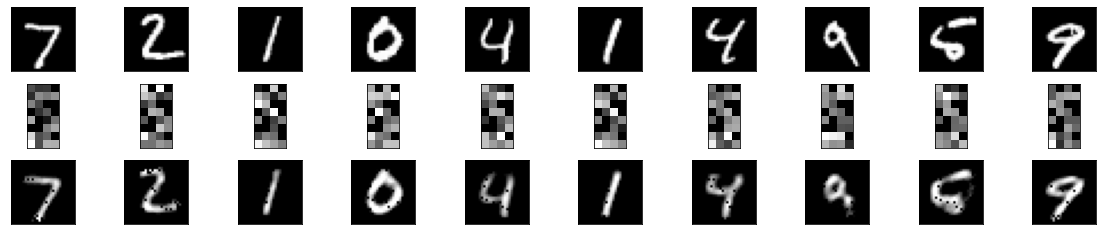

In [ ]:
plot_reconstructions(model)

Can you replace the `MSELoss` with a `BCEWithLogitsLoss`?
BCE with Logit Loss give worse results than MSELoss 

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.702512
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.690976
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.687381
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.687401
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.684343
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.684290
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.683137
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.681914
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.680136
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.679884
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.677872
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.678378
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.677793
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.678067
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.675963
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.676772
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.676135
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.676713
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.675574
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.674115
Train Epoch: 6 [51200/60000 (85%)]	

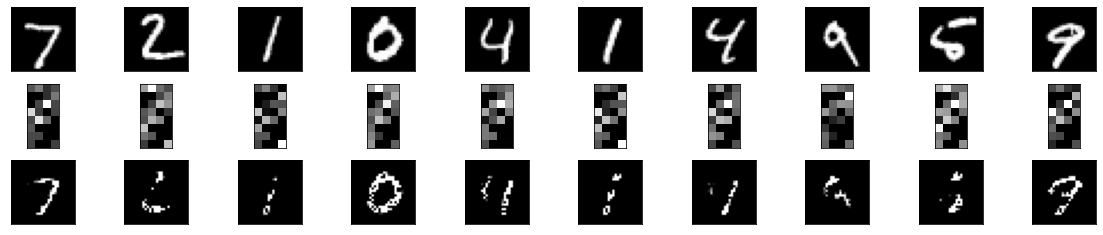

In [ ]:
model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())

loss_bce = torch.nn.BCEWithLogitsLoss()
train_model(model, loss_bce,data_loader=train_loader,epochs=10,optimizer=optimizer)

plot_reconstructions(model)

# 2. Implement a denoising AE:


Use previous code and with minimal modifications, transform your AE in a denoising AE. Now, you first apply some noise to your input and try to recover the original data at the output. For the noise, you can add some random noise or erase some of the pixels. In this last case, you should obtain something like: 

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/denoising_AE.png)

The first line corresponds to the original digit, the second line to the noisy version of the digit given as input to your network, the third line is the associated code amd the last line is the denoised digit obtained by your decoder from the code.

In [ ]:
# You need first to modify the training process by adding noise to your data
# Hint if you want to erase pixels: https://stackoverflow.com/questions/49216615/is-there-an-efficient-way-to-create-a-random-bit-mask-in-pytorch

def add_noise(inpu, noise): 
    noise = torch.randn_like(inpu)*noise
    return inpu + noise

def train_denoiser(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
        #
        # your code here to create the noisy_data
        #
            data = data.view([-1, 784]).to(device)
            noisy_data = add_noise(data, noise)
            noisy_data = noisy_data.to(device)
            optimizer.zero_grad()
            output = model(noisy_data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
                
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
train_denoiser(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer, noise=0.1)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.702078
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.690007
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.687042
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.686752
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.684878
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.682906
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.683268
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.682180
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.680703
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.680840
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.679410
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.679365
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.678714
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.678947
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.677839
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.678776
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.677524
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.676630
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.678075
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.677450
Train Epoch: 6 [51200/60000 (85%)]	

In [ ]:
# Now you need to modify the plot function
def plot_denoising(model, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, , the second row is the noisy digits, 
    the third row is the encoded vector and
    the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    
    #
    # your code here to compute
    # noisy_data
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    
    noisy_data = add_noise(data, noise)
    noisy_data = noisy_data.to(device)
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
      
    # encoded_imgs
    # decoded_imgs
    #
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display code
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

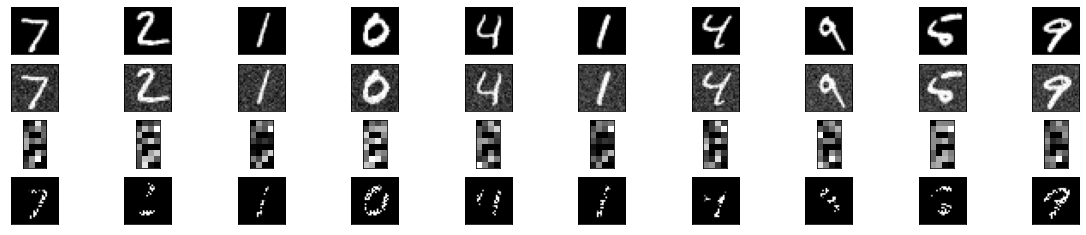

In [ ]:
plot_denoising(model, noise=0.1)